# CAB420 Assignment 1B
- First Name: Aidan
- Last Name: Lockwood
- Student Number: 10515402

## Question 1: Person Re-Identification

In [135]:
# Importing the relevant libraries
import os 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import glob
import random

from sklearn import decomposition, discriminant_analysis
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

import keras
from keras import layers

Utility functions used to preprocess the data - taken from the template

In [114]:
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

def split_validation(X, Y, id_cutoff = 250):

    train_X = X[Y <= id_cutoff, :]
    train_Y = Y[Y <= id_cutoff]

    val_X = X[Y > id_cutoff, :]
    val_Y = Y[Y > id_cutoff]

    return train_X, train_Y, val_X, val_Y

def sample_gallery_and_probe(X, Y):
    
    # storage
    gallery_X = []
    gallery_Y = []
    probe_X = []
    probe_Y = []

    # find unique IDs
    unique_ids = np.unique(Y)
    # loop through unique IDs
    for i in unique_ids:
        # pull out samples for the current ID
        samples = X[Y == i, :]
        # need at least two samples for use the ID
        if samples.shape[0] >= 2:
            # first sample for a subject stored in the gallery
            gallery_X.append(samples[0, :])
            gallery_Y.append(i)
            # second sample stored in the probe
            probe_X.append(samples[1, :])
            probe_Y.append(i)
            # any other images for the subject are ignored

    # return extracted data
    return np.array(gallery_X), np.array(gallery_Y), np.array(probe_X), np.array(probe_Y)

def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))
    # split validation data
    train_X, train_Y, val_X, val_Y = split_validation(train_X, train_Y)

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y

def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')

def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()

def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')


def evaluate_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 12])

    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize = 'true', ax = ax)
    conf.ax_.set_title('Training Set Performance')

    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize = 'true', ax = ax)
    conf.ax_.set_title('Test Set Performance')

    predict = model.predict(X_test)
    print(f'Accuracy: {str(sum(predict == Y_test) / len(Y_test))}%')

def get_ranked_histogram_l2_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L2 distance here. Note that L2
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=2)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')   

## Step 1: Prepreprocessing

(4711, 128, 64, 3)
(4711,)
(1222, 128, 64, 3)
(1222,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


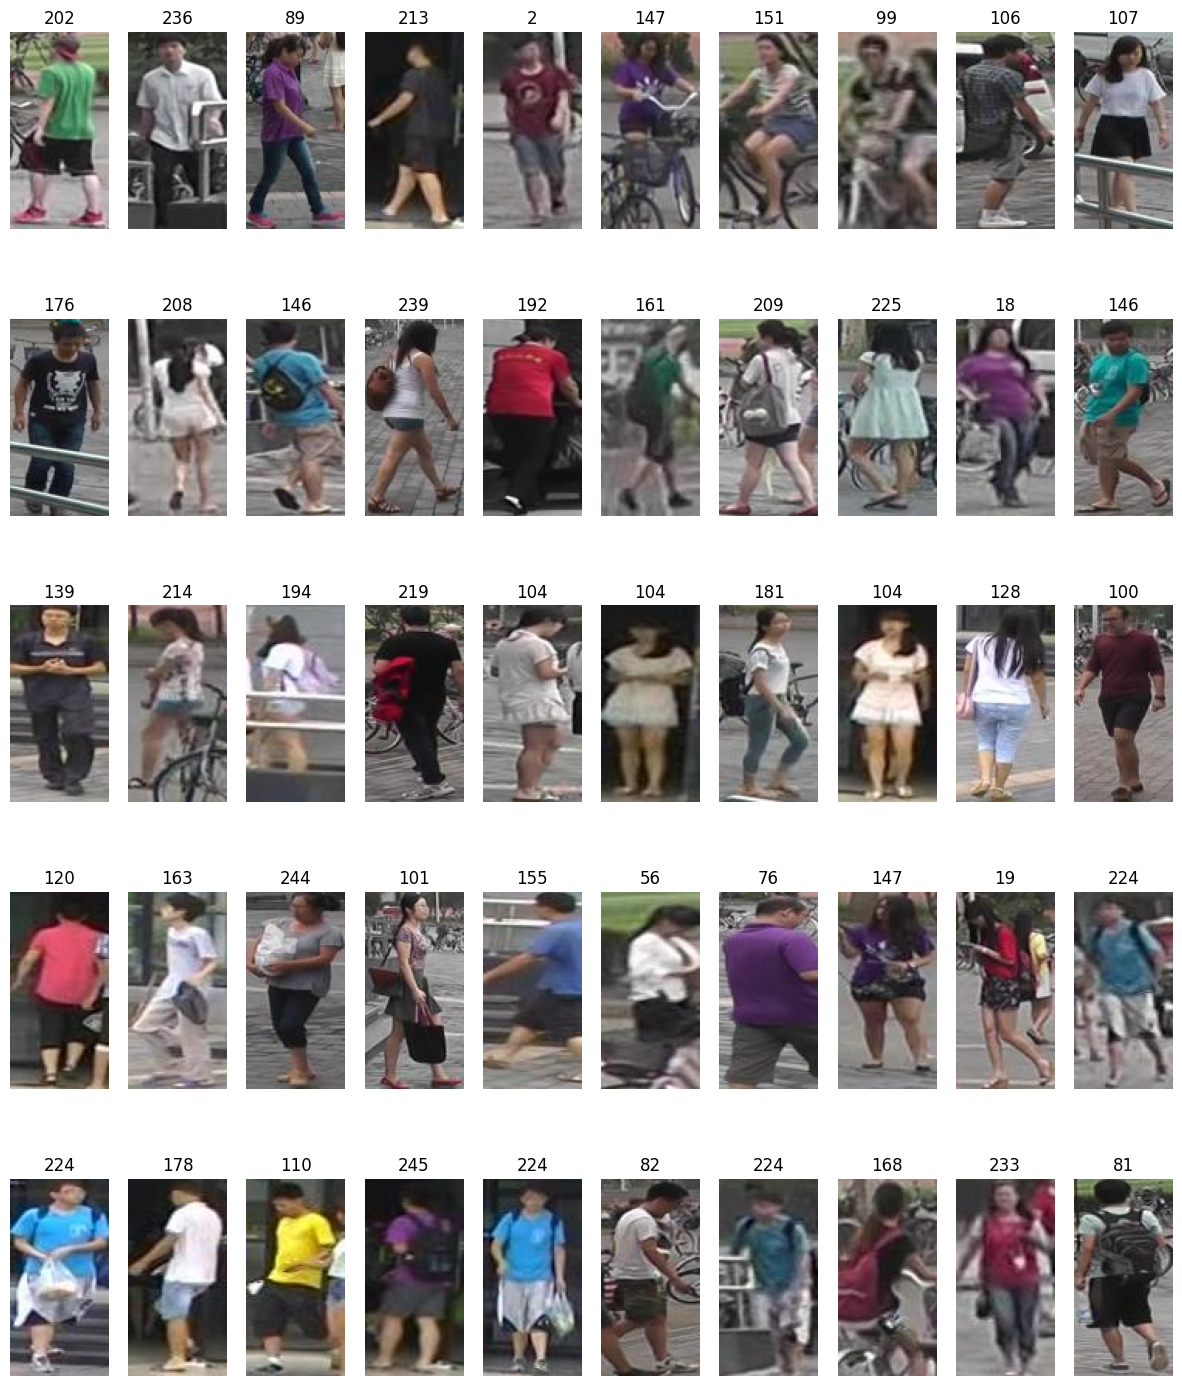

In [115]:
train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('data/Q1/')

print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

plot_images(train_X, train_Y)


In [116]:
val_gallery_X, val_gallery_Y, val_probe_X, val_probe_Y = sample_gallery_and_probe(val_X, val_Y)

Scaling the data

In [117]:
def standardisation(data):
    mean = np.mean(vectorise(data), axis = 0)
    sigma = np.std(vectorise(data), axis = 0)
    X_standardised = (vectorise(data) - mean) / sigma
    return mean, sigma, X_standardised

In [118]:
train_mean, train_sigma, train_X_standardised = standardisation(train_X)
probe_mean, probe_sigma, probe_X_standardised = standardisation(probe_X)
gallery_mean, gallery_sigma, gallery_X_standardised = standardisation(gallery_X)

In [119]:
pca = decomposition.PCA()
pca.fit(train_X_standardised)

transformed_train_X = pca.transform(train_X_standardised)

In [120]:
transformed_gallery_X = pca.transform(gallery_X_standardised)
transformed_probe_X = pca.transform(probe_X_standardised)

In [121]:
reduced_train_X = transformed_train_X[:, 0:2]
reduced_gallery_X = transformed_gallery_X[:, 0:2]
reduced_probe_X = transformed_probe_X[:, 0:2]

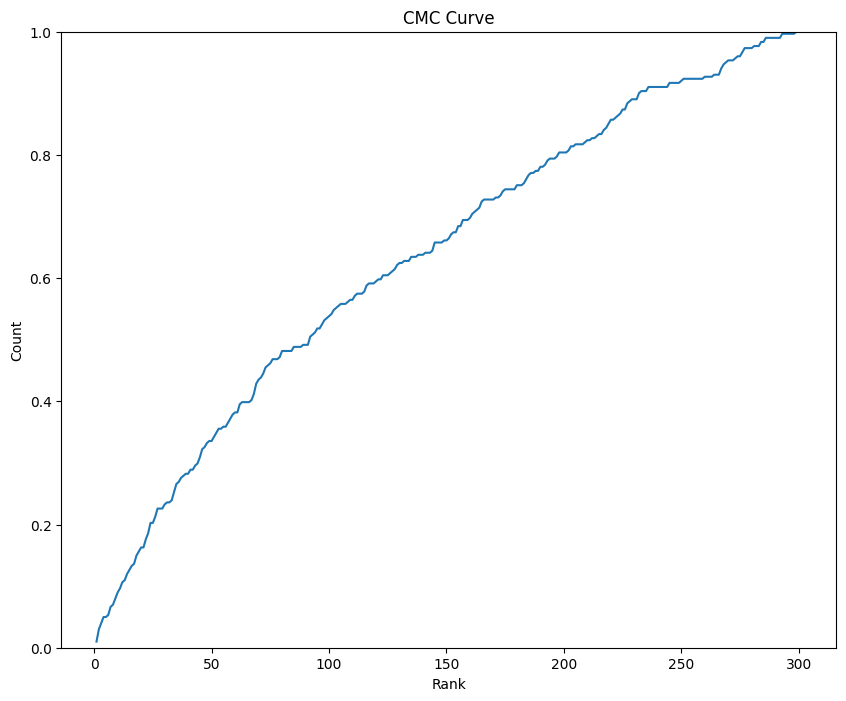

In [122]:
ranked_histogram = get_ranked_histogram_l2_distance(reduced_gallery_X, gallery_Y, reduced_probe_X, probe_Y)

pca_cmc = ranked_hist_to_CMC(ranked_histogram)
plot_cmc(pca_cmc)

In [123]:
transformed_gallery_X.shape

(301, 4711)

Applying LDA to the PCA space (standardised)

In [124]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()

lda.fit(transformed_train_X, train_Y)

transformed_train_X_pca_lda = lda.transform(transformed_train_X)
transformed_gallery_X_pca_lda = lda.transform(transformed_gallery_X)
transformed_probe_X_pca_lda = lda.transform(transformed_probe_X)

In [125]:
reduced_train_X_pca_lda = transformed_train_X_pca_lda[:, 0:2]
reduced_gallery_X_pca_lda = transformed_gallery_X_pca_lda[:, 0:2]
reduced_probe_X_pca_lda = transformed_probe_X_pca_lda[:, 0:2]

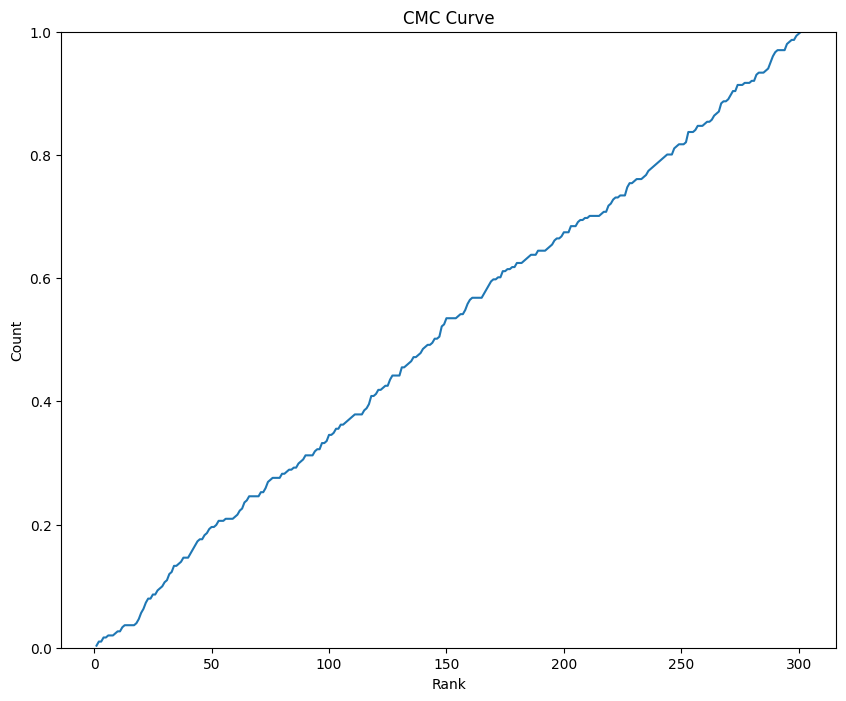

In [126]:
ranked_histogram = get_ranked_histogram_l2_distance(reduced_gallery_X_pca_lda, gallery_Y, reduced_probe_X_pca_lda, probe_Y)

pca_lda_cmc = ranked_hist_to_CMC(ranked_histogram)
plot_cmc(pca_lda_cmc)

Just LDA by itself

In [127]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()

lda.fit(train_X_standardised, train_Y)

LinearDiscriminantAnalysis()

In [128]:
lda_train_X = lda.transform(train_X_standardised)
lda_gallery_X = lda.transform(gallery_X_standardised)
lda_probe_X = lda.transform(probe_X_standardised)


In [129]:
reduced_train_X_lda = lda_train_X[:, 0:2]
reduced_gallery_X_lda = lda_gallery_X[:, 0:2]
reduced_probe_X_lda = lda_probe_X[:, 0:2]

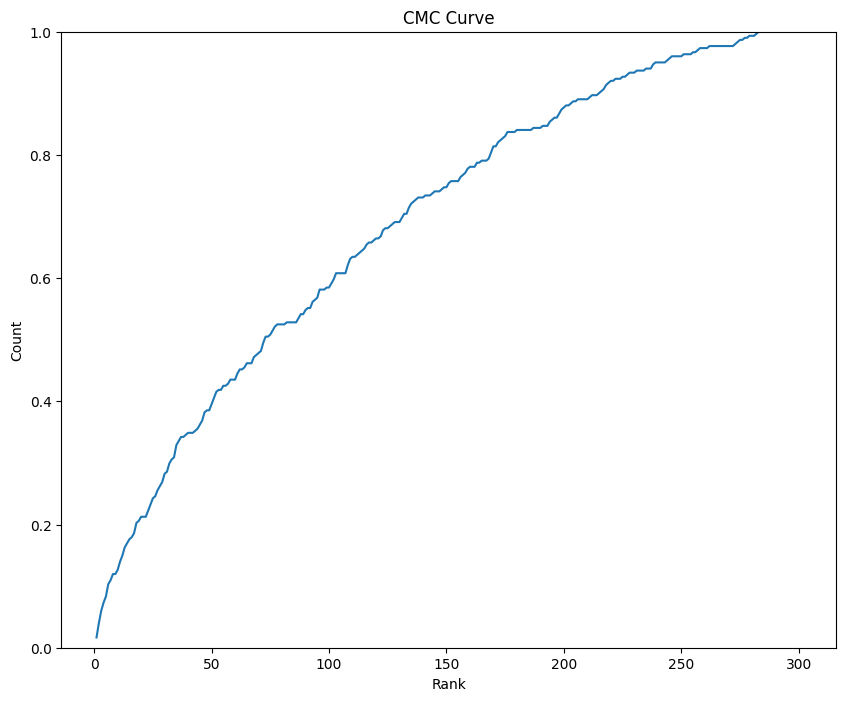

In [130]:
ranked_histogram = get_ranked_histogram_l2_distance(reduced_gallery_X_lda, gallery_Y, reduced_probe_X_lda, probe_Y)
lda_cmc = ranked_hist_to_CMC(ranked_histogram)

plot_cmc(lda_cmc)

Text(0.5, 1.0, 'CMC Curve')

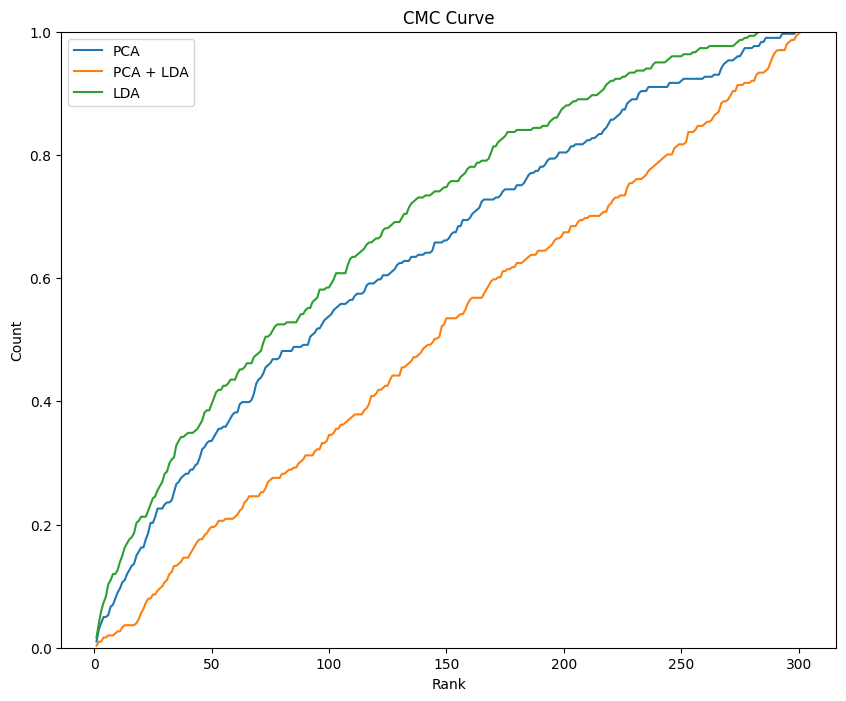

In [131]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, len(pca_cmc)+1), pca_cmc)
ax.plot(range(1, len(pca_lda_cmc)+1), pca_lda_cmc)
ax.plot(range(1, len(lda_cmc)+1), lda_cmc)
ax.legend(['PCA', 'PCA + LDA', 'LDA'])
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_ylim([0, 1.0])
ax.set_title('CMC Curve')   

Text(0.5, 1.0, 'First Two LDA Components')

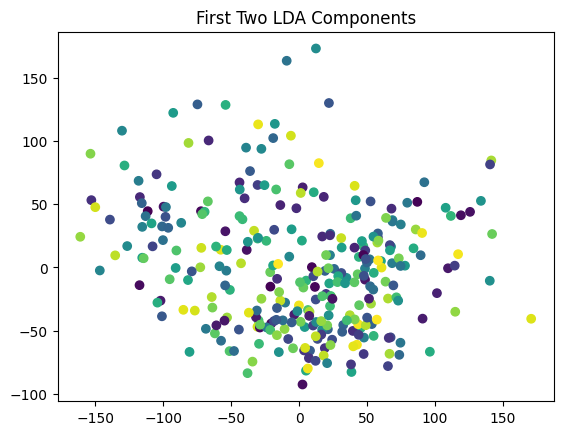

In [132]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(transformed_probe_X[:,0], transformed_probe_X[:,1], c=probe_Y)
ax.set_title('First Two LDA Components')

## Part 2: Deep Learning Method

Dividing the data into the triplets

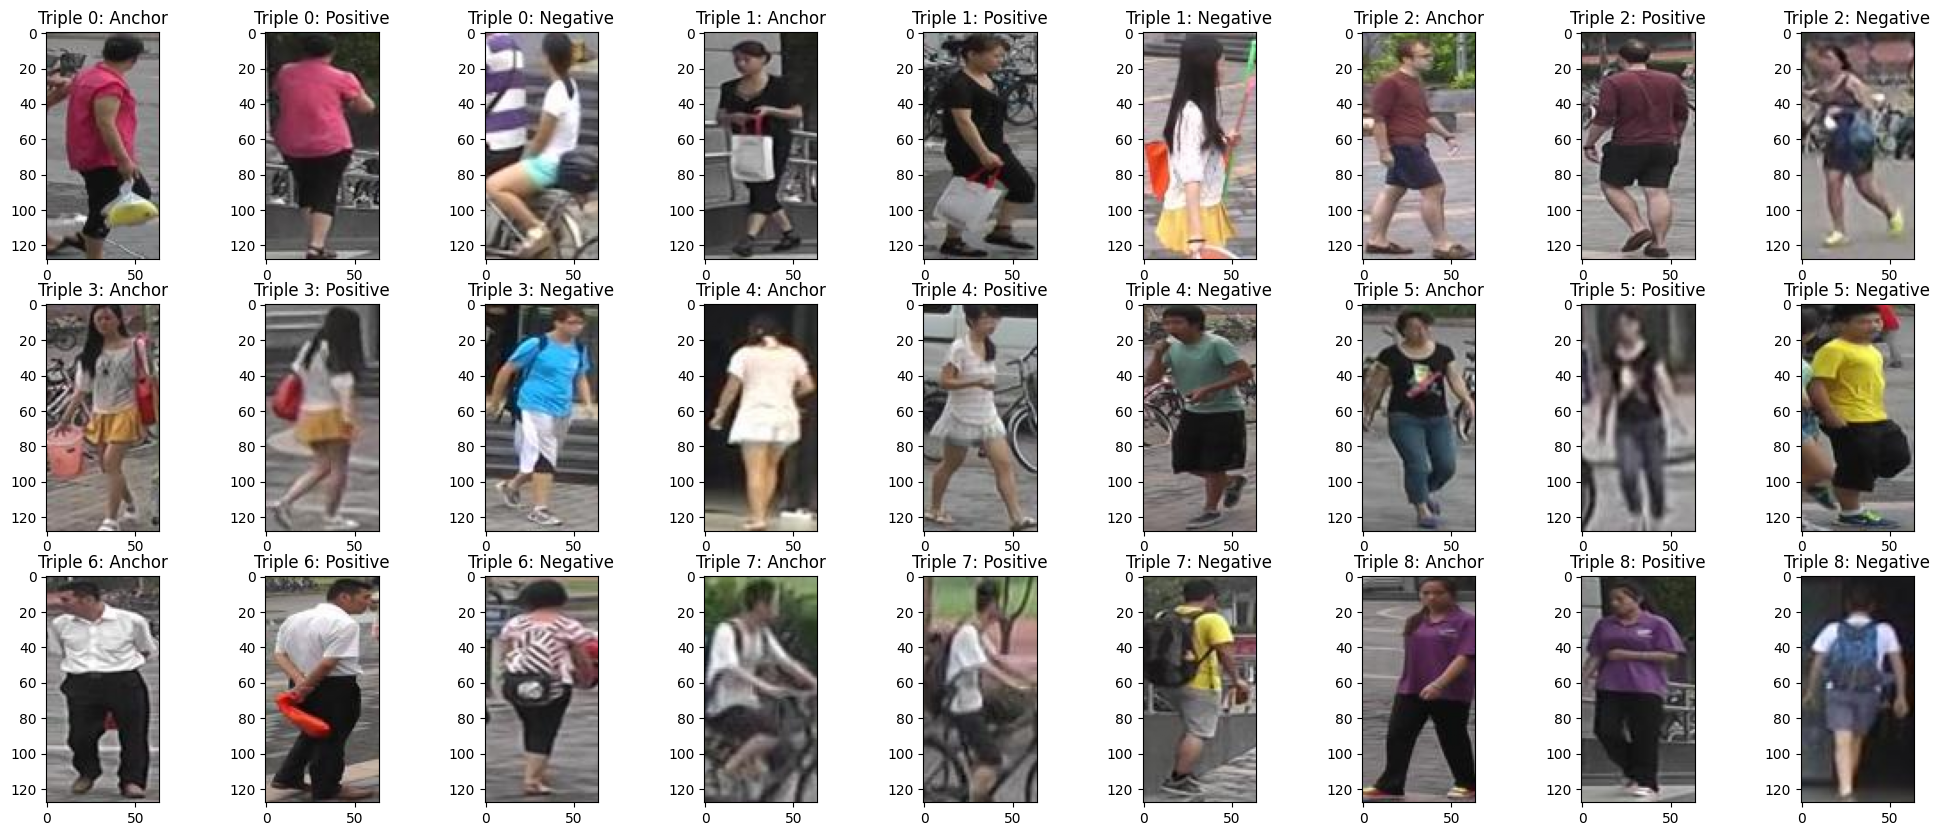

In [133]:
triplet_data = get_triplet_data(train_X, train_Y, 1000)
plot_triplets(triplet_data)

Developing the network

In [154]:
def create_conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):

    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = create_conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

dummy = keras.Input((128, 64, 3), name = 'Anchor')
base_network = vgg_net(dummy, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(32, activation=None)(base_network)
base_network = keras.models.Model(inputs = dummy, outputs = embedding_layer)

input_anchor = keras.Input((128, 64, 3), name = 'Anchor')
input_positive = keras.Input((128, 64, 3), name = 'Positive')
input_negative = keras.Input((128, 64, 3), name = 'Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

triplet_loss_layer = TripletLossLayer(1, name = 'TripletLossLayer')([embedding_anchor, embedding_positive, embedding_negative])

triplet_network = keras.models.Model(inputs = [input_anchor, input_positive, input_negative], outputs = triplet_loss_layer)

Preparing the triplet data 

In [162]:
triplet_train_X = get_triplet_data(train_X, train_Y, 1000)
triplet_val_X = get_triplet_data(val_X, val_Y, 1000)
triplet_gallery_X = get_triplet_data(gallery_X, gallery_Y, 1000)
triplet_probe_X = get_triplet_data(probe_X, probe_Y, 1000)

In [ ]:
triplet_network.compile(optimizer = keras.optimizers.Adam(), jit_compile = False)
triplet_network.fit(x = triplet_train_X, y = None, epochs = 10, batch_size = 128, validation_data = (triplet_val_X, None))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - loss: 56.1750

ValueError: Layer "functional_3" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 128, 64, 3) dtype=float32>]